In [2]:
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import MeanShift
from sklearn.metrics import pairwise_distances

In [3]:
pd.set_option("display.max_rows", 250000)

In [4]:
df = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/GSE59114.csv', header = 1)
df1 = df.T
df1.columns = df1.loc['Gene Symbol'].reset_index()
df1 = df1.drop(['Gene Symbol', 'UCSC transcripts'])
df1.columns = [x[1] for x in df1.columns]
df1.columns = df1.columns.str.replace("'", "")
df1.shape

(1434, 8422)

In [5]:
import re
df2 = df1[~df1.index.str.contains('biol_replicate')]
df2 = df2.drop(['\'Young LT-HSC\'','\'Young ST-HSC\'', '\'Young MPP\'','\'Old LT-HSC\'', '\'Old ST-HSC\'','Old MPP\''])

In [6]:
df2.index = df2.index.str.replace(r'[^a-zA-Z]', '')

np.unique(df2.index)


array(['oldLTHSC', 'oldMPP', 'oldSTHSC', 'youngLTHSC', 'youngMPP',
       'youngSTHSC'], dtype=object)

In [7]:
scaler = StandardScaler()
dfscale2 = scaler.fit_transform(df2)

# PCA fitting

In [8]:
pca = PCA(n_components = 10)
pcafitdf2 = pca.fit_transform(dfscale2)


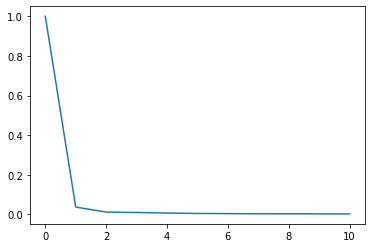

In [9]:
variance = np.insert(pca.explained_variance_ratio_, 0, 1)
x = [i for i in range(variance.shape[0])]

plt.plot(x, variance)

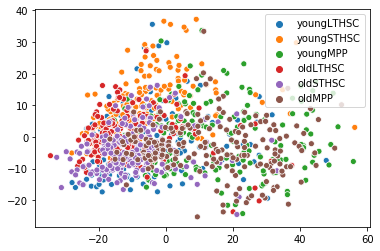

In [10]:
import seaborn as sns
sns.scatterplot(pcafitdf2[:,0], pcafitdf2[:,1], hue = df2.index)

# UMAP fitting

In [11]:
umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=.2,
                      metric='correlation').fit_transform(dfscale2)

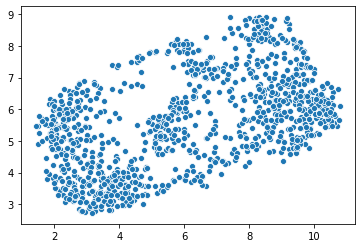

In [17]:
sns.scatterplot(umap_results[:,0], umap_results[:,1])

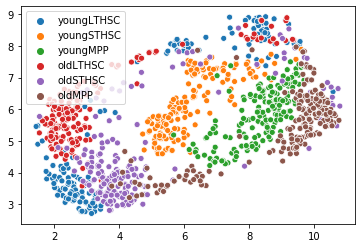

In [12]:
sns.scatterplot(umap_results[:,0], umap_results[:,1], hue = df2.index)

In [13]:
import random
cell_types = np.unique(df2.index).tolist()
c = []
for i in range(len(cell_types)):
    r = random.random()
    g = random.random()
    b = random.random()
    color = (r,g,b)
    c.append(color)

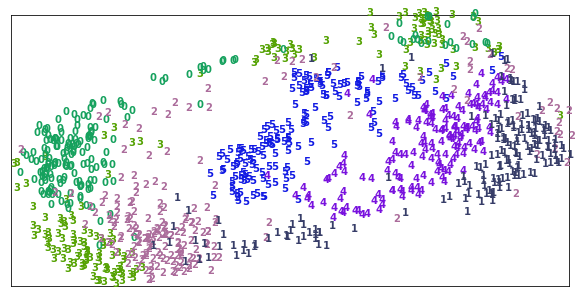

In [14]:
plt.figure(figsize = (10,5))
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i][0], umap_results[i][1], str(cell_types.index(df2.index[i])),
    color = c[int(cell_types.index(df2.index[i]))],
    fontdict={'weight': 'bold', 'size': 10})
    


plt.xlim(min(umap_results, key = lambda x:x[0])[0], max(umap_results, key = lambda x:x[0])[0])
plt.ylim(min(umap_results, key = lambda x:x[1])[1], max(umap_results, key = lambda x:x[1])[1])
plt.xticks([])
plt.yticks([])

plt.show()

# DBSCAN fitting

In [15]:
dbscan_clusters5 = DBSCAN(eps=129.6, min_samples=1,  metric = 'euclidean', algorithm = 'ball_tree')

# Fit model
clusters5 = dbscan_clusters5.fit_predict(dfscale2)
clusters5_trans = clusters5
np.unique(clusters5).shape

(5,)

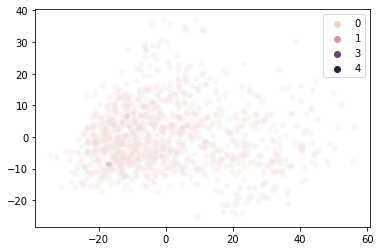

In [18]:
sns.scatterplot(pcafitdf2[:,0], pcafitdf2[:,1], alpha = .2, hue = clusters5_trans)

# Gaussian fitting

In [19]:
gmm = GaussianMixture(n_components = 6)
gmm.fit(dfscale2)
gmmcluster = gmm.fit_predict(dfscale2)

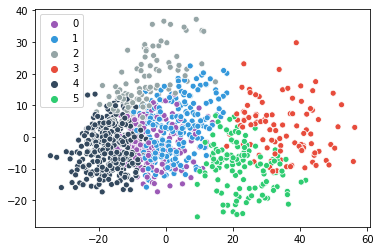

In [20]:
sns.scatterplot(pcafitdf2[:,0], pcafitdf2[:,1], alpha= 1, hue = gmmcluster, palette = {0:"#9b59b6", 1:"#3498db", 2:"#95a5a6", 3:"#e74c3c", 4:"#34495e", 5:"#2ecc71"})

# Kernel PCA fitting

In [21]:
kpcarbf = KernelPCA(n_components=2, kernel = 'rbf', gamma =100)
kcompsrbf = kpcarbf.fit_transform(dfscale2)

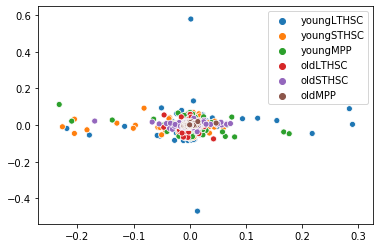

In [22]:
sns.scatterplot(kcompsrbf[:,0], kcompsrbf[:,1], alpha= 1, hue = df2.index)

# K Means fitting

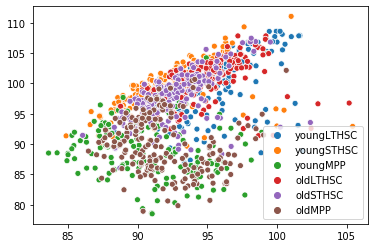

In [23]:
km = KMeans(n_clusters = 6, random_state=42)
kmdata = km.fit_transform(dfscale2)
sns.scatterplot(kmdata[:,0], kmdata[:, 1], hue = df2.index)

# Hierarchical fitting

In [24]:
agg = AgglomerativeClustering(n_clusters = 2, affinity='euclidean',linkage = 'ward')
agg.fit(dfscale2)
aggdata = agg.fit_predict(dfscale2

SyntaxError: unexpected EOF while parsing (<ipython-input-24-c1c1cdd7d6dc>, line 3)

In [ ]:
sns.scatterplot(pcafitdf2[:,0], pcafitdf2[:,1], hue = aggdata, palette = {0:"#9b59b6", 1:"#3498db", 2:"#95a5a6", 3:"#e74c3c", 4:"#34495e", 5:"#2ecc71"})

In [ ]:
plt.figure(figsize=(20,10))
dendrogram(linkage(dfscale2, method = 'ward'))
plt.show()

# Mean shift fitting

In [ ]:
ms = MeanShift(bandwidth=120)
ms.fit(dfscale2)
msclusters = ms.fit_predict(dfscale2)
pd.Series(msclusters).value_counts()

In [ ]:
sns.scatterplot(pcafitdf2[:,0], pcafitdf2[:,1], hue = ms)

# Feature Manipulation

In [ ]:
dfcelltypes = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcelltypes['youngLTHSC'] = df2[df2.index == 'youngLTHSC'].mean()
dfcelltypes['youngSTHSC'] = df2[df2.index == 'youngSTHSC'].mean()
dfcelltypes['youngMPP'] = df2[df2.index == 'youngMPP'].mean()
dfcelltypes['oldLTHSC'] = df2[df2.index == 'oldLTHSC'].mean()
dfcelltypes['oldSTHSC'] = df2[df2.index == 'oldSTHSC'].mean()
dfcelltypes['oldMPP'] = df2[df2.index == 'oldMPP'].mean()


In [ ]:
dfcellbroad = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcellbroad['HSC'] = df2[df2.index.str.contains('HSC')].mean()
dfcellbroad['MPP'] = df2[df2.index.str.contains('MPP')].mean()
dfcellbroad['HSC/MPP'] = dfcellbroad['HSC']/dfcellbroad['MPP']
dfcellbroad.sort_values(by = ['HSC/MPP','HSC','MPP'], ascending = False).head(2)


In [ ]:
plt.hist(dfcellbroad.HSC, color = 'r', alpha = 0.3)
plt.hist(dfcellbroad.MPP, color = 'b', alpha = 0.3)

In [ ]:
dfcbnonzeros = dfcellbroad[dfcellbroad != 0].dropna()
dfcbnonzeros.sort_values(by = ['HSC/MPP','HSC','MPP'], ascending = False).head(2)

In [ ]:
y = [x for x in df2.index]

k = 100
kbest = SelectKBest(k=k, score_func=f_classif)
X_best_feat = kbest.fit_transform(dfscale2,y)

X_best_feat = pd.DataFrame(X_best_feat, columns=df2.columns[kbest.get_support()])

trimcol = X_best_feat.columns
trimcol


In [ ]:
df2trim = df2.drop(trimcol, axis = 1).copy()
df2sel = df2[trimcol]
print(df2trim.shape, df2.shape)

In [ ]:
scaler2 = StandardScaler()
scaler3 = StandardScaler()
dfscale2trim = scaler2.fit_transform(df2trim)
dfscale2sel = scaler3.fit_transform(df2sel)

In [ ]:
umap_resultstrim = umap.UMAP(n_neighbors=10,
                      min_dist=.2,
                      metric='correlation').fit_transform(dfscale2trim)
sns.scatterplot(umap_resultstrim[:,0], umap_resultstrim[:,1], hue = df2.index)

In [ ]:
umap_resultssel = umap.UMAP(n_neighbors=10,
                      min_dist=.2,
                      metric='correlation').fit_transform(dfscale2sel)
sns.scatterplot(umap_resultssel[:,0], umap_resultssel[:,1], hue = df2.index)

In [ ]:
pcatrim = PCA(n_components = 10)
pcafitdf2t = pcatrim.fit_transform(dfscale2trim)

In [ ]:
pcasel = PCA(n_components = 2)
pcafitdf2s = pcasel.fit_transform(dfscale2sel)

In [ ]:
variancet = np.insert(pcatrim.explained_variance_ratio_, 0, 1)
x = [i for i in range(variancet.shape[0])]

plt.plot(x, variancet)

In [ ]:
variances = np.insert(pcasel.explained_variance_ratio_, 0, 1)
x = [i for i in range(variances.shape[0])]

plt.plot(x, variances)

In [ ]:
import seaborn as sns
sns.scatterplot(pcafitdf2t[:,0], pcafitdf2t[:,1], hue = df2.index)

In [ ]:
sns.scatterplot(pcafitdf2s[:,0], pcafitdf2s[:,1], hue = df2.index)

In [ ]:
gmm = GaussianMixture(n_components = 6)
gmm.fit(dfscale2sel)
cluster = gmm.fit_predict(dfscale2sel)

In [ ]:
sns.scatterplot(pcafitdf2s[:,0], pcafitdf2s[:,1], hue = cluster, alpha = 1)

In [ ]:
sns.scatterplot(pcafitdf2s[:,0], pcafitdf2s[:,1], alpha = .5,hue = cluster)
sns.scatterplot(pcafitdf2t[:,0], pcafitdf2t[:,1], hue = cluster, alpha = .1, palette = {0:"#9b59b6", 1:"#3498db", 2:"#95a5a6", 3:"#e74c3c", 4:"#34495e", 5:"#2ecc71"}
)

In [ ]:
aggtrim = AgglomerativeClustering(n_clusters = 50, affinity='cosine',linkage = 'complete')
aggtrimdata = aggtrim.fit(dfscale2trim)
plt.figure(figsize=(20,10))
dendrogram(linkage(dfscale2trim, method = 'ward'))
plt.show()

In [ ]:
aggsel = AgglomerativeClustering(n_clusters = 50, affinity='cosine',linkage = 'complete')
aggseldata = aggsel.fit(dfscale2sel)
plt.figure(figsize=(20,10))
dendrogram(linkage(dfscale2sel, method = 'ward'))
plt.show()

In [ ]:
dfcellbroad['HSC'].corr(dfcellbroad['MPP'])

In [ ]:
plt.scatter(dfcellbroad['HSC'], dfcellbroad['MPP'])

In [ ]:
clusteringsel = MeanShift(bandwidth=12.5).fit(dfscale2sel)
np.unique(clusteringsel.labels_).shape

In [ ]:
clusteringtrim = MeanShift(bandwidth=20).fit(dfscale2trim)
np.unique(clusteringtrim.labels_).shape

In [ ]:
sns.scatterplot(pcafitdf2t[:,0], pcafitdf2t[:,1], alpha = .5, hue = clusteringtrim.labels_)